In [1]:
import sys
import numpy as np

from matplotlib import pyplot as plt


import cardio.dataset as ds
from cardio import EcgBatch
index = ds.FilesIndex(path='D:\Projects/cardio/cardio/tests/training2017/A*.hea', no_ext=True, sort=True)

In [2]:
from keras.models import Sequential
from keras.layers import Conv1D,  UpSampling1D, Activation, LeakyReLU, Dropout,BatchNormalization
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


In [9]:
def generator(batch_size):
    def get_batch(batch_size=1):
        eds = ds.Dataset(index, batch_class=EcgBatch)
        batch = eds.next_batch(batch_size=batch_size,shuffle=True, unique_labels=['A', 'N', 'O'])
        batch_with_data = batch.load(fmt='wfdb', components=['signal', 'meta'])
        return np.array([batch_with_data[i].signal[0][:9000] for i in batch_with_data.indices ])
    while True:
        signal=get_batch(batch_size=batch_size)
        while np.shape(signal)[-1] !=9000:
            signal=get_batch(batch_size=batch_size)
        noise_sigs = np.zeros_like(signal)
        for i,s in enumerate(signal):
            n_sin = 10
            siglen = len(s)
            t = np.linspace(0, 30, siglen)
            for j in range(n_sin):
                a = np.random.uniform(0, 0.1)
                omega = np.random.uniform(3, 4)
                phi = np.random.uniform(0, 2 * np.pi)
                noise_sigs[i] += a * np.sin(omega * t + phi)
                a = np.random.uniform(0, 0.2)
                omega = np.random.uniform(0.1, 0.8)
                phi = np.random.uniform(0, 2 * np.pi)
                noise_sigs[i] += a * np.sin(omega * t + phi)
            noise_sigs[i] += s
        yield noise_sigs.reshape(-1,9000,1),signal.reshape(-1,9000,1)
    

In [10]:
a=[i for i in generator(2)]

KeyboardInterrupt: 

In [11]:
class Autoencoder(object):
    
    def __init__(self, length=9000, channel=1):

        self.length = length
        self.channel = channel
        self.E = None   # endcoder
        self.D = None   # decoder
        self.AE = None  # Auto encoder model
        
    def encoder(self):
        if self.E:
            return self.E
        self.E = Sequential(name='encoder')
        depth = 64
        dropout = 0.6
        input_shape = (self.length, self.channel)
        self.E.add(Conv1D(depth*1, 3, strides=1, input_shape=(9000,1),\
            padding='same',name='con_1'))
        self.E.add(LeakyReLU(alpha=0.2,name='leak_1'))
        self.E.add(Dropout(dropout,name='drop_1'))

        self.E.add(Conv1D(depth*2, 5, strides=2, padding='same',name='con_2'))
        self.E.add(LeakyReLU(alpha=0.2,name='leak_2'))
        self.E.add(Dropout(dropout,name='drop_2'))

        self.E.add(Conv1D(depth*4, 5, strides=2, padding='same',name='con_3'))
        self.E.add(LeakyReLU(alpha=0.2,name='leak_3'))
        self.E.add(Dropout(dropout,name='drop_3'))

        self.E.summary()
        return self.E
    
    def decoder(self):
        if self.D:
            return self.D
        self.D = Sequential(name='decoder')
        dropout = 0.6
        depth = 64*4
        dim = 16
        
        self.D.add(UpSampling1D(input_shape=(2250, 256),name='up1'))
        self.D.add(Conv1D(int(depth/2), 5, padding='same',name='con4'))
        self.D.add(BatchNormalization(momentum=0.9,name='b1'))
        self.D.add(Activation('relu',name='rel1'))

        self.D.add(UpSampling1D(size=(2),name='up2'))
        self.D.add(Conv1D(int(depth/4), 5, padding='same',name='con5'))
        self.D.add(BatchNormalization(momentum=0.9,name='b2'))
        self.D.add(Activation('relu',name='rel2'))
        
        # Out: 256 x 256 x 1 grayscale image [0.0,1.0] per pix
        self.D.add(Conv1D(int(depth/8), 5, padding='same',name='con6'))
        self.D.add(Activation('tanh',name='tanh'))
        
        self.D.add(Conv1D(1, 5, padding='same',name='con7'))
        self.D.add(Activation('linear',name='lin1'))
        self.D.summary()
        return self.D
    
    def autoencoder_model(self):
        if self.AE:
            return self.AE
        optimizer = Adam(lr=0.0002,beta_1=0.5, decay=0)
        self.AE = Sequential(name='aemodel')
        self.AE.add(self.encoder())
        self.AE.add(self.decoder())
        self.AE.compile(loss='mean_squared_error', optimizer=optimizer,\
            metrics=['accuracy'])
        self.AE.summary()
        return self.AE

In [12]:
model=Autoencoder().autoencoder_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
con_1 (Conv1D)               (None, 9000, 64)          256       
_________________________________________________________________
leak_1 (LeakyReLU)           (None, 9000, 64)          0         
_________________________________________________________________
drop_1 (Dropout)             (None, 9000, 64)          0         
_________________________________________________________________
con_2 (Conv1D)               (None, 4500, 128)         41088     
_________________________________________________________________
leak_2 (LeakyReLU)           (None, 4500, 128)         0         
_________________________________________________________________
drop_2 (Dropout)             (None, 4500, 128)         0         
_________________________________________________________________
con_3 (Conv1D)               (None, 2250, 256)         164096    
__________

In [13]:
model.fit_generator(generator(10), steps_per_epoch=50, epochs=10)

Epoch 1/10
50/50 [==============================] - 76s 2s/step - loss: 0.0974 - acc: 0.0087
Epoch 2/10
50/50 [==============================] - 5s 103ms/step - loss: 0.0356 - acc: 0.0095
Epoch 3/10
50/50 [==============================] - 5s 106ms/step - loss: 0.0330 - acc: 0.0088
Epoch 4/10
50/50 [==============================] - 5s 103ms/step - loss: 0.0282 - acc: 0.0094
Epoch 5/10
50/50 [==============================] - 5s 103ms/step - loss: 0.0289 - acc: 0.0095
Epoch 6/10
50/50 [==============================] - 5s 103ms/step - loss: 0.0279 - acc: 0.0099
Epoch 7/10
50/50 [==============================] - 5s 103ms/step - loss: 0.0271 - acc: 0.0092
Epoch 8/10
50/50 [==============================] - 5s 103ms/step - loss: 0.0273 - acc: 0.0091
Epoch 9/10
50/50 [==============================] - 5s 103ms/step - loss: 0.0264 - acc: 0.0097
Epoch 10/10
50/50 [==============================] - 5s 103ms/step - loss: 0.0265 - acc: 0.0093


In [25]:
a=[i for i in generator(1)]

KeyboardInterrupt: 

In [26]:
batch_size=1
eds = ds.Dataset(index, batch_class=EcgBatch)
batch = eds.next_batch(batch_size=batch_size,shuffle=True, unique_labels=['A', 'N', 'O'])
batch_with_data = batch.load(fmt='wfdb', components=['signal', 'meta'])

In [30]:
signal=batch_with_data[batch_with_data.indices[0]].signal

In [31]:
noise_sigs = np.zeros_like(signal)
for i,s in enumerate(signal):
            n_sin = 10
            siglen = len(s)
            t = np.linspace(0, 30, siglen)
            for j in range(n_sin):
                a = np.random.uniform(0, 0.1)
                omega = np.random.uniform(3, 4)
                phi = np.random.uniform(0, 2 * np.pi)
                noise_sigs[i] += a * np.sin(omega * t + phi)
                a = np.random.uniform(0, 0.2)
                omega = np.random.uniform(0.1, 0.8)
                phi = np.random.uniform(0, 2 * np.pi)
                noise_sigs[i] += a * np.sin(omega * t + phi)
            noise_sigs[i] += s

In [33]:
noise_sigs.reshape(-1,9000,1)

array([ 0.12337987,  0.15473552,  0.19309981, ...,  1.38913886,
        1.26776882,  1.14437647])

In [34]:
output=model.predict(noise_sigs.reshape(-1,9000,1))

In [35]:
output

array([[[ 0.15525262],
        [-0.18913487],
        [-0.08575758],
        ..., 
        [ 0.4463838 ],
        [ 0.17916624],
        [ 0.1637015 ]]], dtype=float32)

(0, 2000)

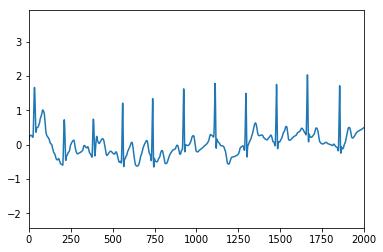

In [37]:
plt.plot(noise_sigs.reshape(-1,9000,1)[0].T[0])
plt.xlim(0,2000)

(0, 2000)

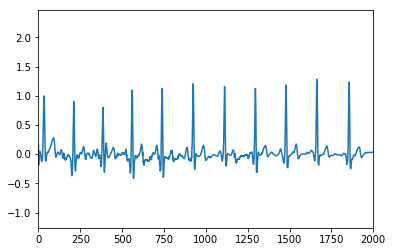

In [36]:
plt.plot(output[0].T[0])
plt.xlim(0,2000)